In [68]:
import pandas as pd
import numpy as np
import os
import re
from functools import partial
from nltk.corpus import stopwords
import nltk
from scipy.sparse import csr_matrix
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

In [69]:
data = pd.read_csv("../dataset/train.csv", encoding="latin1")
test_data = pd.read_csv("../dataset/test.csv", encoding="latin1")

df = pd.concat([data, test_data])
df.shape

(32296, 10)

In [70]:
df.head(5)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [72]:
df.drop(columns=['textID', 'selected_text', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)', 'Country'], axis=1, inplace=True)
df.head()

,text,sentiment,Time of Tweet,Age of User
0,"I`d have responded, if I were going",neutral,morning,0-20
1,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30
2,my boss is bullying me...,negative,night,31-45
3,what interview! leave me alone,negative,morning,46-60
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,noon,60-70


In [73]:
df.dropna(inplace=True)
df["sentiment"].value_counts()


sentiment
neutral     12547
positive     9685
negative     8782
Name: count, dtype: int64

In [74]:
df.head()

def clean_text(raw_text):
    text = re.sub(re.compile('<.*?>'), '', str(raw_text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    text = str(text).lower()
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text

df['text'] = df['text'].apply(clean_text)
df['text'].head(5)

0                                      id have responded if i were going
1                             sooo sad i will miss you here in san diego
2                                                 my boss is bullying me
3                                          what interview leave me alone
4    sons of why couldnt they put them on the releases we already bought
Name: text, dtype: object

In [75]:
nltk.download('stopwords')
stopwords = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopwords]).apply(lambda x:" ".join(x))
df['text'].tail(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\k4ty2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3529                                                              3 im tired cant sleep try
3530    alone old house thanks net keeps alive kicking whoever invented net wanna kiss hair
3531                  know mean little dog sinking depression wants move someplace tropical
3532                                             sutra next youtube video gonna love videos
3533                                             httptwitpiccom4woj2 omgssh ang cute ng bby
Name: text, dtype: object

In [76]:
def remove_urls(text):
    pattern = re.compile(r'\b(?:http|https|www)\S*')
    return pattern.sub(r'', text)

df["text"] = df["text"].apply(remove_urls)
df = df.reset_index(drop=True)
df.head(5)


,text,sentiment,Time of Tweet,Age of User
0,id responded going,neutral,morning,0-20
1,sooo sad miss san diego,negative,noon,21-30
2,boss bullying,negative,night,31-45
3,interview leave alone,negative,morning,46-60
4,sons couldnt put releases already bought,negative,noon,60-70


In [77]:
y = df['sentiment']
X = df.drop(['sentiment'], axis=1)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

cv = CountVectorizer()
X_text = cv.fit_transform(X["text"])


encoder_time = OneHotEncoder(sparse_output=False)
new_time = encoder_time.fit_transform(df[['Time of Tweet']])

encoder_age = OneHotEncoder(sparse_output=False)
new_age = encoder_age.fit_transform(df[['Age of User']])

X_combined = hstack([X_text, new_time, new_age])

X_train, X_test, y_train,y_test = train_test_split(X_combined, y, test_size=0.15, random_state=1)


In [78]:
model = LogisticRegression(n_jobs=1)
model.fit(X_train, y_train)

LogisticRegression(n_jobs=1)

0.6825703846980443


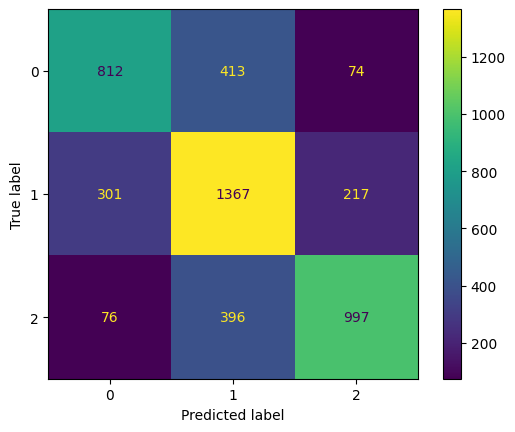

In [79]:

y_pred = model.predict(X_test)
score_lr = accuracy_score(y_test, y_pred)
print(score_lr)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [80]:
def map_label(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"
    
def age_to_range(age):
    if 0 <= age <= 20:
        return '0-20'
    elif 21 <= age <= 30:
        return '21-30'
    elif 31 <= age <= 45:
        return '31-45'
    elif 46 <= age <= 60:
        return '46-60'
    elif 61 <= age <= 70:
        return '60-70'
    else:
        return '70-100'

def text_clean(text):
    text = re.sub(re.compile('<.*?>'), '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    clean_text = " ".join([word for word in text.split() if word not in stopwords])
    return clean_text

def lime_predict_proba(texts, time_matrix, age_matrix):
    features = []
    for t in texts:
        t_clean = text_clean(t)
        t_vector = cv.transform([t_clean])
        t_feature = hstack([t_vector, time_matrix, age_matrix])
        features.append(t_feature)
    feature_matrix = np.vstack([f.toarray() for f in features])
    feature_matrix = csr_matrix(feature_matrix)
    return model.predict_proba(feature_matrix)
    
def manual_testing(text, age, time):
    text = text_clean(text)
    text_vector = cv.transform([text])
    
    time_matrix = encoder_time.transform([[time]])

    age = age_to_range(age)
    age_matrix = encoder_age.transform([[age]])
    
    feature = hstack([text_vector, time_matrix, age_matrix]) 
    
    pred = model.predict(feature)

    explainer = LimeTextExplainer(class_names=["negative", "neutral", "positive"])
    
    lime_predict = partial(lime_predict_proba, time_matrix=time_matrix, age_matrix=age_matrix)
    explanation = explainer.explain_instance(text, lime_predict, num_features=10)
    
    print("\nTop 3 tokens with the strongest attributions::")
    top_important_words = explanation.as_list()[:3]
    for word, score in top_important_words:
        print(f"{word}: {score}")
        
    return map_label(pred)

text = "I dont like it. I hate it"
age = 20
time = 'morning'

result = manual_testing(text, age, time)
print(f"Text: {text}")
print(result)
print()


Top 3 tokens with the strongest attributions::
hate: -0.4365234446618961
like: -0.05955085941390852
dont: -0.05425269316175696
Text: I dont like it. I hate it
The Text Sentement is Negative

